In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import os
from panel_segmentation import panel_detection as pnl
import pvdrdb_tools as pvdrdb
import pvlib
import power_routine as pwr
from statistics import mode
import requests
from geopy.distance import geodesic
import json
import pprint
from IPython.display import display, HTML


# Set up pretty printer
pp = pprint.PrettyPrinter()

# Declare the different types of API keys for the analysis. To sign up for a Google Maps API key, go here: 
# https://developers.google.com/maps/documentation/javascript/get-api-key?utm_source=google&utm_medium=cpc&utm_campaign=FY20-Q3-global-demandgen-displayonnetworkhouseads-cs-GMP_maps_contactsal_saf_v2&utm_content=text-ad-none-none-DEV_c-CRE_460848633529-ADGP_Hybrid%20%7C%20AW%20SEM%20%7C%20BKWS%20~%20Google%20Maps%20API%20Key-KWID_43700035216023629-kwd-298247230705-userloc_1014524&utm_term=KW_google%20maps%20api%20key-ST_google%20maps%20api%20key

google_maps_api_key = "YOUR GOOGLE MAPS API KEY HERE"

# Metadata Error Analysis

The following example illustrates the use of the Panel-Segmentation and PVAnalytics packages, which leverage satellite imagery and time series analysis, respectively, to estimate system metadata parameters.

In [3]:
with open("./examples/2107_system_metadata.json", "r") as f:
    site_metadata = json.load(f)
    
# Get the associated mounting configuration data
mount_data = site_metadata['Mount']['Mount 0']
gt_tracking = mount_data['tracking']
gt_type = mount_data['type']
gt_azimuth = mount_data['azimuth']
gt_tilt = mount_data['tilt']

print("Associated mounting information:")
pp.pprint(mount_data)
# Get the associated timezone
tz = site_metadata['System']['timezone_code']

site_df = pd.read_csv("./examples/2107_electrical_data.csv", index_col=0)
site_df.index = pd.to_datetime(site_df.index)
site_df.index = site_df.index.tz_localize(tz, ambiguous='NaT')
site_df = site_df.loc[site_df.index.dropna()].copy()

Associated mounting information:
{'azimuth': 180.0,
 'manufacturer': 'Schletter',
 'model': '',
 'mount_id': 17263,
 'name': 'mnt_fss_1',
 'tilt': 25.0,
 'tracking': False,
 'type': 'ground'}


## 1. Run Panel-Segmentation

The [Panel-Segmentation](https://github.com/NREL/Panel-Segmentation) package contains deep learning algorithms and computer vision techniques to analyze satellite imagery for the presence of solar installations, and installs' associated mounting configurations and azimuths. Here, we use the PanelDetection class in the package to detect the mentioned features.

In [4]:
pan_seg = pnl.PanelDetection()

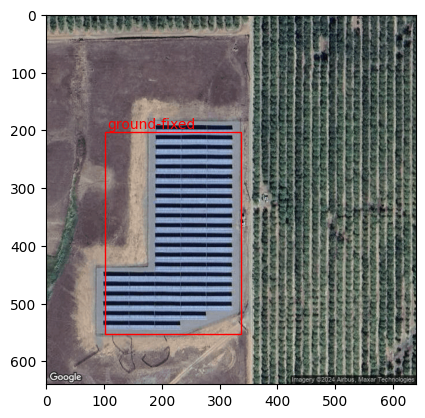

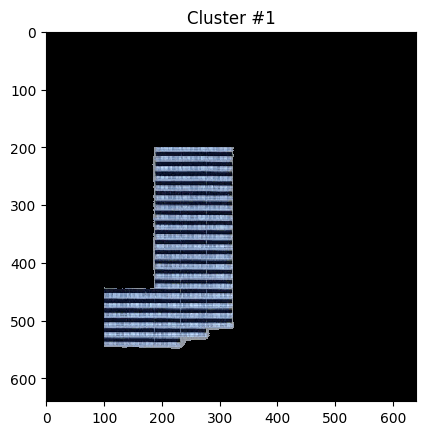

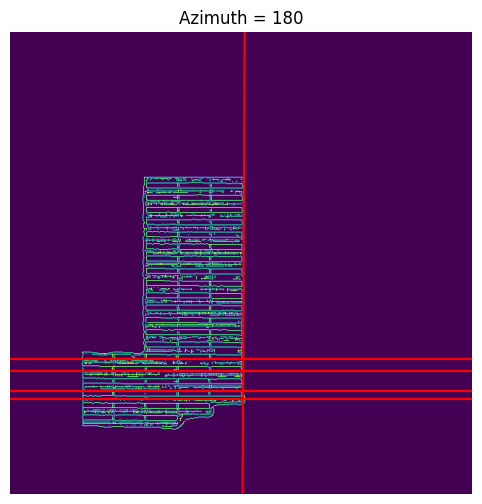

In [5]:
# Declare parameters
az_tilt_match_found = False
mount_match_found = False
lat = site_metadata["Site"]["latitude"]
long = site_metadata["Site"]["longitude"]
sys = site_metadata["System"]["system_id"]
file_name = "./satellite_images/" + str(sys) + "_img.png"

# ASK ABOUT API KEY

# Run deep learning algorithm
site_analysis_dict = pan_seg.runSiteAnalysisPipeline(
            latitude=lat,
            longitude=long,
            google_maps_api_key=google_maps_api_key,
            file_name_save_img=file_name,
            file_name_save_mount="./mounting_config/" +
            str(sys) +
            '_mounting_config.png',
            file_path_save_azimuth='./azimuth/' +
            str(sys) + "_",
            generate_image=True)
site_analysis_dict['system_id'] = sys

In [6]:
# Pretty print the Panel-Segmentation dictionary of results
pp.pprint(site_analysis_dict)

{'associated_azimuths': [180.0],
 'mounting_type': ['ground-fixed'],
 'system_id': 2107}


## 2. PVAnalytics

The [PVAnalytics](https://pvanalytics.readthedocs.io/en/stable/) package contains functions that assess the quality of systems’ PV data. In this section, we use PVAnalytics routines estimate system mounting configuration, azimuth, and tilt. AC power stream data is used to do this. 

## 2a) Estimate Data with Power Streams through PVAnalytics

We read in the NSRDB data for the associated system, as it will be used in estimating azimuth and tilt.

In [7]:
# Get the associated NSRDB data for the system
psm3 = pd.read_csv("./examples/2107_psm3_data.csv",
                   parse_dates=True,
                   index_col=0)
psm3.index = psm3.index.tz_convert(tz)

Next, we use PVAnalytics functions to estimate the azimuth, tilt, and mounting configuration based on the AC power data and NSRDB data.

In [8]:
# Run the PVAnalytics power routine all of the datastreams
pva_list = list()
for col in list(site_df.columns):
    power_time_series = site_df[col]
    predicted_mounting_config, (predicted_azimuth, predicted_tilt) = \
            pwr.run_power_stream_routine(power_time_series,
                                     lat, long, psm3)
    pva_list.append({"column": col,
                     "mounting_config": predicted_mounting_config,
                     "azimuth": predicted_azimuth,
                     "tilt": predicted_tilt
                     })

pva_df = pd.DataFrame(pva_list)

In [9]:
# Print out the results as a table
display(HTML(pva_df.to_html()))

,column,mounting_config,azimuth,tilt
0,inv_01_ac_power_inv_149583,FIXED,177.449060,23.353696
1,inv_02_ac_power_inv_149588,UNKNOWN,176.916213,18.186348
2,inv_03_ac_power_inv_149593,FIXED,176.792976,19.392711
3,inv_04_ac_power_inv_149598,FIXED,177.565359,30.676332
4,inv_05_ac_power_inv_149603,FIXED,177.298806,19.407058
5,inv_06_ac_power_inv_149608,FIXED,176.314440,34.387936
6,inv_07_ac_power_inv_149613,FIXED,177.380791,36.571696
7,inv_08_ac_power_inv_149618,FIXED,177.128805,15.952331
8,inv_09_ac_power_inv_149623,FIXED,177.251021,22.124784
9,inv_10_ac_power_inv_149628,FIXED,176.677385,20.559439


## 2c) Compare Metadata with Estimation

We take the median azimuth and tilt, and mode mounting configuration across all of the power data streams and compare it against the metadata. These comparisons are performed with two checks: a PVAnalytics check and a Panel-Segmentation check. 

For mounting configuration, if the mode mounting configuration (fixed vs.tracking) is the same as the metadata, then we accept the metadata. For azimuth and tilt, if the estimates are within 15 degrees (for azimuth) and 5 degrees (for tilt) of the provided metadata, we accept the metadata as ground-truth. Otherwise, we manually verify system azimuth, tilt, or mounting configuration using Google Earth satellite imagery and Google Street View.

In [10]:
# Take the median mounting config, azimuth, and tilt across all of the power data streams
median_az, median_tilt = (round(pva_df['azimuth'].median(), 1),
                          round(pva_df['tilt'].median(), 1))
mode_mount_type = max(set(list(pva_df["mounting_config"])),
                 key=list(pva_df["mounting_config"]).count)


print("PVA median azimuth across data streams: " + str(median_az) + " deg")
print("PVA median tilt across data streams: " + str(median_tilt) + " deg")

# PVANALYTICS CHECKS
pva_az_tilt_match_found, pva_mount_match_found = \
    pwr.pvanalytics_mount_check(estimated_az=median_az, 
                                estimated_tilt=median_tilt, 
                                estimated_mount=mode_mount_type,
                                gt_az=gt_azimuth,
                                gt_tilt=gt_tilt,
                                gt_mount=gt_tracking, 
                                system_id=sys)
# PANEL-SEGMENTATION CHECKS
pva_mount_type = max(set(site_analysis_dict['mounting_type']),
                     key=list(site_analysis_dict['mounting_type']).count)
for index, item in enumerate(site_analysis_dict['associated_azimuths']):
    az = site_analysis_dict['associated_azimuths'][index]
    mount = site_analysis_dict['mounting_type'][index]
    pan_az_match_found, pan_mount_match_found = \
        pwr.panel_segmentation_mount_check(estimated_az=az,
                                           estimated_mount=mount,
                                           gt_az=gt_azimuth,
                                           gt_mount=gt_tracking, 
                                           system_id=sys)     
    # If we find a match, end the sequence.
    if pan_az_match_found and pan_mount_match_found:
        break

PVA median azimuth across data streams: 176.6 deg
PVA median tilt across data streams: 20.6 deg
PVAnalytics az-tilt match found for system 2107
PVAnalytics mount match found for system 2107
Panel-Segmentation az match found for system 2107
Panel-Segmentation mount match found for system 2107


## 3. Summarize Results

We record and summarize all the results as a dictionary.

In [11]:
# Record all of the results to the list 
az_tilt_mount_results = {"system_id": sys,
                         "gt_azimuth": gt_azimuth,
                         "gt_tilt": gt_tilt,
                         "gt_mount": gt_type,
                         "gt_tracking": gt_tracking,
                         "pan_seg_azimuths": site_analysis_dict['associated_azimuths'],
                         "pan_seg_mounts": site_analysis_dict['mounting_type'],
                         "pan_seg_az_match": pan_az_match_found,
                         "pan_seg_mount_match": pan_mount_match_found,
                         "pva_azimuth_median": median_az,
                         "pva_tilt_median": median_tilt,
                         "pva_mount_mode": mode_mount_type,
                         "pva_az_tilt_match": pva_az_tilt_match_found,
                         "pva_mount_match": pva_mount_match_found
                         }

pp.pprint(az_tilt_mount_results)

{'gt_azimuth': 180.0,
 'gt_mount': 'ground',
 'gt_tilt': 25.0,
 'gt_tracking': False,
 'pan_seg_az_match': True,
 'pan_seg_azimuths': [180.0],
 'pan_seg_mount_match': True,
 'pan_seg_mounts': ['ground-fixed'],
 'pva_az_tilt_match': True,
 'pva_azimuth_median': 176.6,
 'pva_mount_match': True,
 'pva_mount_mode': 'FIXED',
 'pva_tilt_median': 20.6,
 'system_id': 2107}
